# 一、加载常用库

In [1]:
from glob import glob
import numpy as np
import pandas as pd
from solo import *

%matplotlib inline
from glob import glob
import warnings #不显示乱七八糟的warning
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/Users/mahui/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 二、数据获取

In [2]:
luna_path = './'
luna_subset_path = luna_path + 'sample_patients/'
file_list = glob(luna_subset_path + "*.mhd")
df_node = pd.read_csv(luna_path + 'csv_files/' + 'annotations.csv')

output_path = luna_path + 'npy/'
working_path = luna_path + 'output/'

In [3]:
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
df_node.head(5)

,seriesuid,coordX,coordY,coordZ,diameter_mm,file
25,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,46.188539,48.402806,-108.578632,13.596471,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
26,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.392044,76.771663,-123.321911,4.343200,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
1002,1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754...,119.208776,11.450374,-165.039862,26.837081,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
1003,1.3.6.1.4.1.14519.5.2.1.6279.6001.487268565754...,-37.901617,55.027912,-80.002605,17.718729,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...
1145,1.3.6.1.4.1.14519.5.2.1.6279.6001.910435939545...,68.243850,83.940751,-296.892458,7.068564,./sample_patients/1.3.6.1.4.1.14519.5.2.1.6279...


In [4]:
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those 
        # load the data once
        ct_scan, origin, spacing = load_itk(img_file)
        for node_idx, cur_row in mini_df.iterrows():       
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            
            center = np.array([node_x, node_y, node_z])
            voxel_coordinates = world_2_voxel(center, origin, spacing)

100%|██████████| 3/3 [00:00<00:00,  8.60it/s]


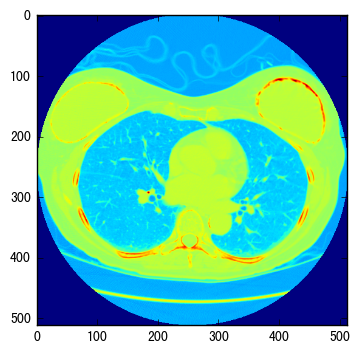

In [9]:
plt.imshow(ct_scan[65])

Internal Marker


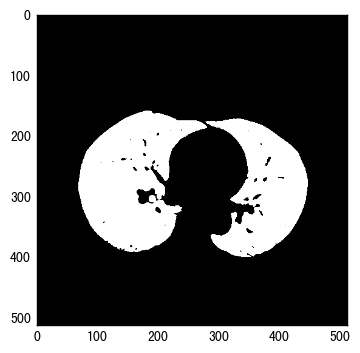

External Marker


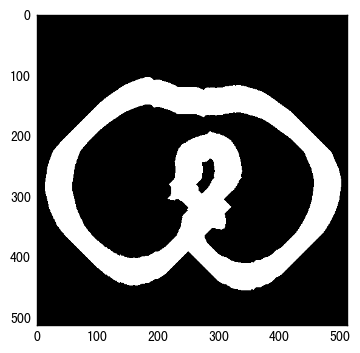

Watershed Marker


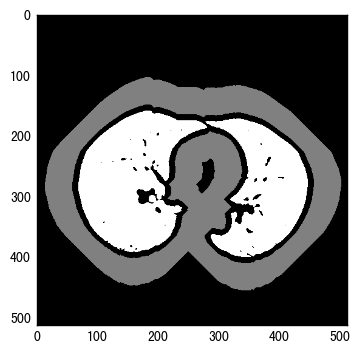

In [6]:
from skimage import measure, morphology, segmentation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage as ndimage


def generate_markers(image):
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    marker_internal = marker_internal_labels > 0
    #Creation of the external Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    #Creation of the Watershed Marker matrix
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

#Show some example markers from the middle        
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(ct_scan[65])
print ("Internal Marker")
plt.imshow(test_patient_internal, cmap='gray')
plt.show()
print ("External Marker")
plt.imshow(test_patient_external, cmap='gray')
plt.show()
print ("Watershed Marker")
plt.imshow(test_patient_watershed, cmap='gray')
plt.show()

Sobel Gradient


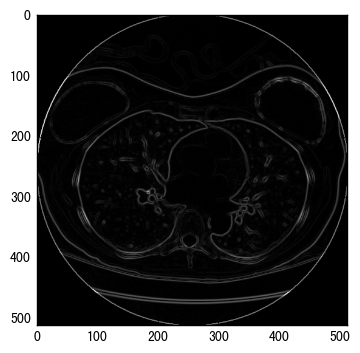

Watershed Image


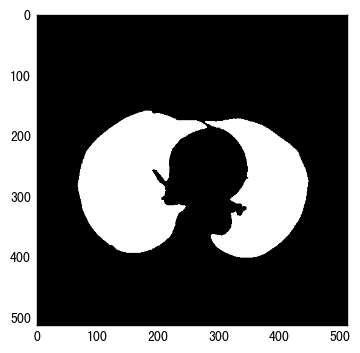

Outline after reinclusion


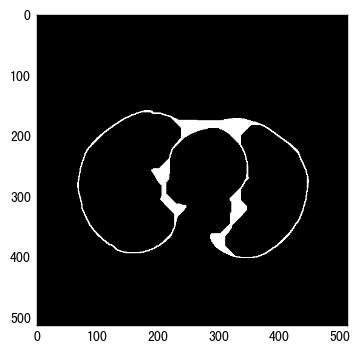

Lungfilter after closing


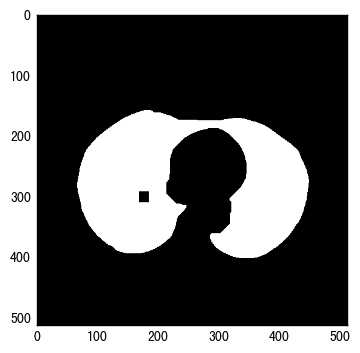

Segmented Lung


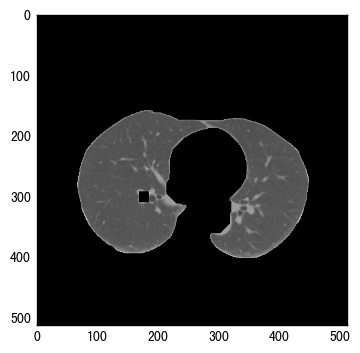

In [7]:
def seperate_lungs(image):
    #Creation of the markers as shown above:
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    #Creation of the Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    #Watershed algorithm
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    #Reducing the image created by the Watershed algorithm to its outline
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    #Performing Black-Tophat Morphology for reinclusion
    #Creation of the disk-kernel and increasing its size a bit
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, 8)
    #Perform the Black-Hat
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    #Use the internal marker and the Outline that was just created to generate the lungfilter
    lungfilter = np.bitwise_or(marker_internal, outline)
    #Close holes in the lungfilter
    #fill_holes is not used here, since in some slices the heart would be reincluded by accident
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    #Apply the lungfilter (note the filtered areas being assigned -2000 HU)
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    return segmented, lungfilter, outline, watershed, sobel_gradient, marker_internal, marker_external, marker_watershed

#Some Testcode:
test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient, test_marker_internal, test_marker_external, test_marker_watershed = seperate_lungs(ct_scan[65])

print ("Sobel Gradient")
plt.imshow(test_sobel_gradient, cmap='gray')
plt.show()
print ("Watershed Image")
plt.imshow(test_watershed, cmap='gray')
plt.show()
print ("Outline after reinclusion")
plt.imshow(test_outline, cmap='gray')
plt.show()
print ("Lungfilter after closing")
plt.imshow(test_lungfilter, cmap='gray')
plt.show()
print ("Segmented Lung")
plt.imshow(test_segmented, cmap='gray')
plt.show()

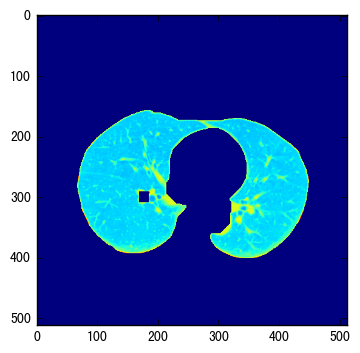

In [8]:
plt.imshow(test_segmented)